# Linear Regression for tim series analysis
Linear regression is not the best model for time series analysis since it does consider only the rolling averages of last n dates and makes a predict rather considering exponential moving averages. However this can serve as a base line model for time series analaysis.

Linear Rregression
ARIMA, SARIMA and LSTM are some of the models for time series prediction.Linear Regression being the simple, ARIMA model being moderate and based on the assumption of stationarity and LSTM models are the complex ones.


In [1]:
!pip install yfinance

     |████████████████████████████████| 63 kB 1.3 MB/s 
     |████████████████████████████████| 6.4 MB 28.0 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


# Load the libraries, fetch the data from Yahoo Finance and perform EDA

[*********************100%***********************]  1 of 1 completed


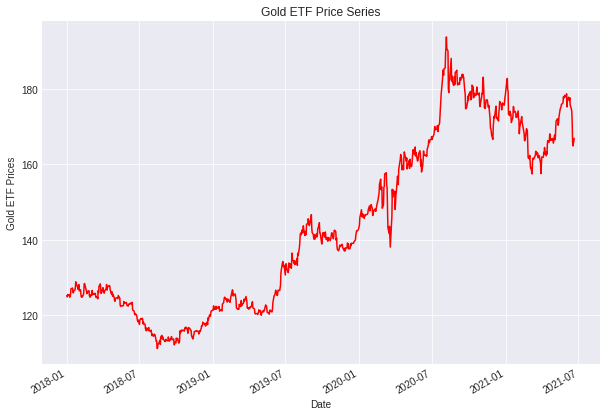

In [2]:
# LinearRegression is a machine learning library for linear regression
from sklearn.linear_model import LinearRegression

# pandas and numpy are used for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn are used for plotting graphs
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

# yahoo finance is used to fetch data
import yfinance as yf

# Read data
Df = yf.download('GLD', '2018-01-01', '2021-6-22', auto_adjust=True)

# Only keep close columns
Df = Df[['Close']]

# Drop rows with missing values
Df = Df.dropna()

# Plot the closing price of GLD
Df.Close.plot(figsize=(10, 7),color='r')
plt.ylabel("Gold ETF Prices")
plt.title("Gold ETF Price Series")
plt.show()

# Rolling average
In statistics, a moving average (rolling average or running average) is a calculation to analyze data points by creating a series of averages of different subsets of the full data set. It is also called a moving mean (MM) or rolling mean and is a type of finite impulse response filter.

Here we create rolling averages of three and nine days and predict based on that data.

In [3]:
# Define explanatory variables
Df['S_3'] = Df['Close'].rolling(window=3).mean()
Df['S_9'] = Df['Close'].rolling(window=9).mean()
Df['next_day_price'] = Df['Close'].shift(-1)

Df = Df.dropna()
X = Df[['S_3', 'S_9']]

# Define dependent variable
y = Df['next_day_price']

# Test train split - 80: 20, fit the model on the data


In [4]:
# Split the data into train and test dataset
t = .8
t = int(t*len(Df))

# Train dataset
X_train = X[:t]
y_train = y[:t]

# Test dataset
X_test = X[t:]
y_test = y[t:]

# Create a linear regression model
linear = LinearRegression().fit(X_train, y_train)
print("Linear Regression model")
print("Gold ETF Price (y) = %.2f * 3 Days MA (x1) \+ %.2f * 9 Days MA (x2) \
+ %.2f (constant)" % (linear.coef_[0], linear.coef_[1], linear.intercept_))

Linear Regression model
Gold ETF Price (y) = 1.09 * 3 Days MA (x1) \+ -0.08 * 9 Days MA (x2) + -0.22 (constant)


# predict and plot the predictions

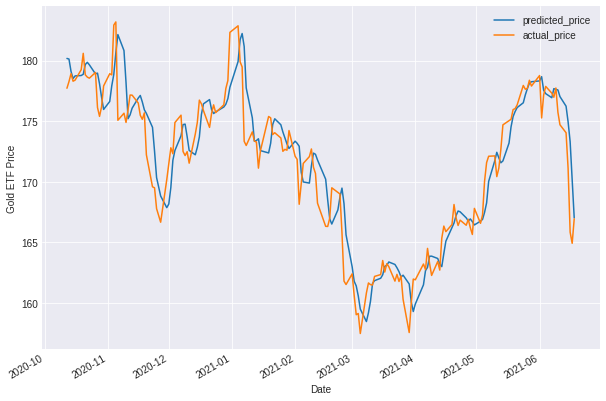

86.72

In [5]:
# Predicting the Gold ETF prices
predicted_price = linear.predict(X_test)
predicted_price = pd.DataFrame(predicted_price, index=y_test.index, columns=['price'])
predicted_price.plot(figsize=(10, 7))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("Gold ETF Price")
plt.show()

# R square
r2_score = linear.score(X[t:], y[t:])*100
float("{0:.2f}".format(r2_score))

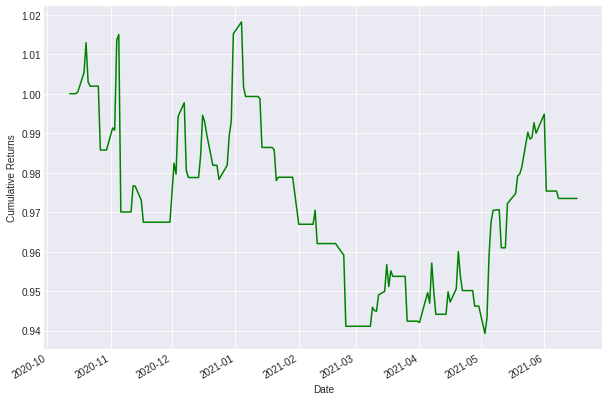

In [6]:
gold = pd.DataFrame()

gold['price'] = Df[t:]['Close']
gold['predicted_price_next_day'] = predicted_price
gold['actual_price_next_day'] = y_test
gold['gold_returns'] = gold['price'].pct_change().shift(-1)

gold['signal'] = np.where(gold.predicted_price_next_day.shift(1) < gold.predicted_price_next_day,1,0)

gold['strategy_returns'] = gold.signal * gold['gold_returns']
((gold['strategy_returns']+1).cumprod()).plot(figsize=(10,7),color='g')
plt.ylabel('Cumulative Returns')
plt.show()

In [7]:
# Calculate sharpe ratio
sharpe = gold['strategy_returns'].mean()/gold['strategy_returns'].std()*(252**0.5)
'Sharpe Ratio %.2f' % (sharpe)

'Sharpe Ratio -0.32'

In [10]:
# import datetime and get today's date
import datetime as dt
current_date = dt.datetime.now()

# Get the data
data = yf.download('GLD', '2020-06-01', current_date, auto_adjust=True)
data['S_3'] = data['Close'].rolling(window=3).mean()
data['S_9'] = data['Close'].rolling(window=9).mean()
data = data.dropna()

# Forecast the price
data['predicted_gold_price'] = linear.predict(data[['S_3', 'S_9']])
data['signal'] = np.where(data.predicted_gold_price.shift(1) < data.predicted_gold_price,"Buy","No Position")

# Print the forecast
data.tail(1)[['signal','predicted_gold_price']].T

[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


Date,2022-04-26
signal,No Position
predicted_gold_price,178.184301


In [11]:
data.to_csv("YahooGoldProce.csv")